In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install -U keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [ ]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import pickle
from time import time
import os

from keras.preprocessing import image
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Model, load_model, model_from_json
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.applications.vgg16 import VGG16


from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding, TimeDistributed, RepeatVector, Reshape, concatenate, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam, RMSprop
from keras.layers.merge import add


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
print(tf.version.VERSION)

2.2.0


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# keras seed fixing
from numpy.random import seed
seed(42)
# tensorflow seed fixin
tf.random.set_seed(42)

## **Loading text file and creating dictionary of image names as keys and their descriptions as values**

In [ ]:
#filename = 'C:/Users/Arun/Documents/Image Captioning/Flickr8k.token.txt'
filename = '/content/drive/My Drive/Image Captioning Data/Text Data/Flickr8k.token.txt'

def load_doc(filename):
    file = open(filename, 'r')
    doc = file.read()
    return doc

doc = load_doc(filename)

In [ ]:
# Creating a dictionary of keys as names of the images and value as caption
def load_description(text):
    mapping = dict()

    for line in text.split('\n'):
    
        tokens = line.split()
        
        if len(line) < 2:
            continue
    
        # take the first token as image id, the rest as description
        image_id, image_desc = tokens[0], tokens[1:]
    
        # extract filename from image id
        image_id = image_id.split('.')[0]
        
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
            mapping[image_id].append(image_desc)
            
    return mapping
    
descriptions = load_description(doc)

In [ ]:
descriptions = dict()
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    
    if len(line) < 2:
        continue
    
    # take the first token as image id, the rest as description
    image_id, image_desc = tokens[0], tokens[1:]
    
    # extract filename from image id
    image_id = image_id.split('.')[0]
    
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    if image_id not in descriptions:
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

# **Data Cleaning - Text**

In [ ]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] =  ' '.join(desc)

In [ ]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))
# 8763

Original Vocabulary Size: 8763


# **Loading clean descriptions for training, dev and test images**

In [ ]:
def load_clean_descriptions(filename):

  train_doc = load_doc(filename)
  train_text = list()

  for line in train_doc.split('\n'):
      identifier = line.split('.')[0]
      train_text.append(identifier)

  train_desc = dict()

  for txt in train_text:
    
      if txt in descriptions:
        
          if txt not in train_desc:
              train_desc[txt] = []
            
          for desc in descriptions[txt]:
              # wrap description in tokens
              train_desc[txt].append('sos ' + desc + ' eos')

  return train_text, train_desc

In [ ]:
### Loading training image text file
filename = '/content/drive/My Drive/Image Captioning Data/Text Data/Flickr_8k.trainImages.txt'

train_text, train_desc = load_clean_descriptions(filename)

print('Dataset: %d' % len(train_text))
#Dataset: 6001

Dataset: 6001


In [ ]:
def load_clean_descriptions_test(filename):

  train_doc = load_doc(filename)
  train_text = list()

  for line in train_doc.split('\n'):
      identifier = line.split('.')[0]
      train_text.append(identifier)

  train_desc = dict()

  for txt in train_text:
    
      if txt in descriptions:
        
          if txt not in train_desc:
              train_desc[txt] = []
            
          for desc in descriptions[txt]:
              # wrap description in tokens
              train_desc[txt].append(desc)

  return train_text, train_desc

In [ ]:
# Loading validation descriptions
# Loading val_image text file

filename = '/content/drive/My Drive/Image Captioning Data/Text Data/Flickr_8k.devImages.txt'

val_text, val_desc = load_clean_descriptions_test(filename)

print('Dataset: %d' % len(val_text))

Dataset: 1001


In [ ]:
# Loading test descriptions
# Loading test_image text file
filename = '/content/drive/My Drive/Image Captioning Data/Text Data/Flickr_8k.testImages.txt'

test_text, test_desc = load_clean_descriptions_test(filename)

print('Dataset: %d' % len(test_text))

Dataset: 1001


# **Data Preprocessing - Images**

In [ ]:
# Get the InceptionV3 model trained on imagenet data
in_layer = Input(shape=(229, 229, 3))
inc_model = InceptionV3(weights='imagenet',input_tensor=in_layer)

# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(inc_model.input, inc_model.layers[-2].output)

#inc_model.summary()

In [ ]:
# Saving inception model
model_new.save('/content/drive/My Drive/Image Captioning Data/Model Weights/inception_weights.h5')

In [ ]:
model_inc = load_model('/content/drive/My Drive/Image Captioning Data/Model Weights/inception_weights.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
### It will take a lot of time to run (approx. 1 - 2 hrs)
# extract features from each photo in the directory

def extract_features(filepath):
    # load the model
    in_layer = Input(shape=(229, 229, 3))
    inc_model = InceptionV3(weights='imagenet',input_tensor=in_layer)
    model_new = Model(inc_model.input, inc_model.layers[-2].output)
    #print(model.summary())
    # extract features from each photo
    file = os.listdir(filepath)
    features = dict()
    
    for name in file:
        
        img = image.load_img(os.path.join(filepath, name), target_size=(229, 229))
        img = image.img_to_array(img)
		 # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
		 # prepare the image for the inception model
        img = preprocess_input(img)
		 # get features
        feature = model_new.predict(img, verbose=0)
        # Reshaping feature from (1, 2048) to (2048, )
        feature = np.reshape(feature, feature.shape[1])
		 # get image id
        image_id = name.split('.')[0]
		 # store feature
        features[image_id] = feature
        print('>%s' % name)
        
    return features

In [ ]:
# extract features from all images
directory = '/content/drive/My Drive/Image Captioning Data/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))

In [ ]:
# save to file
with open(r"C:\Users\Arun\Documents\Image Captioning\Pickle\encoded_images.pl", "wb") as encoded_pickle:
    pickle.dump(features, encoded_pickle)

In [ ]:
features = load(open("/content/drive/My Drive/Image Captioning Data/Pickle/encoded_images.pl", "rb"))
print('Photos: train=%d' % len(features))
# 8091

Photos: train=8091


In [ ]:
# Encoding Train Images

encoding_train = {}

for train_img in train_desc.keys():

    encoding_train[train_img] = features[train_img]

# save to file
with open(r"C:\Users\Arun\Documents\Image Captioning\Pickle\train_images_encoded.pl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
train_features = load(open("/content/drive/My Drive/Image Captioning Data/Pickle/train_images_encoded.pl", "rb"))
print('Photos: train=%d' % len(train_features))
# 6000

Photos: train=6000


In [ ]:
# Encoding dev set images

encoding_val = {}

for val_img in val_desc.keys():

    encoding_val[val_img] = features[val_img]

with open(r"/content/drive/My Drive/Image Captioning Data/Pickle/dev_images_encoded.pl", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle)

In [ ]:
# Loading dev images features

val_features = load(open("/content/drive/My Drive/Image Captioning Data/Pickle/dev_images_encoded.pl", "rb"))
print('Photos: dev=%d' % len(val_features))
# 1000

Photos: dev=1000


In [ ]:
# Encoding Test Images
    
encoding_test = {}

for test_img in test_desc.keys():

    encoding_test[test_img] = features[test_img]

In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_desc.items():
    for cap in val:
        all_train_captions.append(cap)

# Consider only words which occur at least 10 times in the corpus
'''word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('preprocessed words %d ' % len(vocab))
print(len(word_counts))'''

"word_count_threshold = 10\nword_counts = {}\nnsents = 0\nfor sent in all_train_captions:\n    nsents += 1\n    for w in sent.split(' '):\n        word_counts[w] = word_counts.get(w, 0) + 1\n\nvocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]\n\nprint('preprocessed words %d ' % len(vocab))\nprint(len(word_counts))"

In [ ]:
words = [i.split() for i in all_train_captions]


In [ ]:
unique = []
for i in words:
    unique.extend(i)

unique = list(set(unique))

In [ ]:
len(unique)

7578

In [ ]:
# Creating index to word and word to index dictionary
ix_to_word = {}
word_to_ix = {}

ix = 1
for w in unique:
    word_to_ix[w] = ix
    ix_to_word[ix] = w
    ix += 1
    

vocab_size = len(ix_to_word) + 1 # one for appended 0's
vocab_size

7579

In [ ]:
word_to_ix['sos']

4735

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_desc)
print('Description Length: %d' % max_length)
## max_length = 34


Description Length: 34


# **Modelling**

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

## **Preparing Embedding Matrix**

In [ ]:
# Load Glove vectors
glove_dir = "/content/drive/My Drive/Image Captioning Data/GloVe"
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
#Found 400000 word vectors.

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_ix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(7579, 200)

## **Preparing 'Model' to train**

In [ ]:
def create_model():

  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.8)(inputs1)
  fe3 = Dense(256, activation='relu')(fe1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.8)(se1)
  se4 = LSTM(256)(se2)
  decoder1 = add([fe3, se4])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)

  # Setting embedding layer to non-trainable so that embedding matrix won't get updated
  model.layers[2].set_weights([embedding_matrix])
  model.layers[2].trainable = False

  return model

In [ ]:
model = create_model()
#model.summary()

In [ ]:
samples_per_epoch = 0
for ca in all_train_captions:
    samples_per_epoch += len(ca.split())-1

samples_per_epoch

306404

In [ ]:
val_samples_per_epoch = 0
for key, caps in val_desc.items():

  for ca in caps:

    val_samples_per_epoch += len(ca.split())

val_samples_per_epoch

46622

In [ ]:
del model

In [ ]:
model.load_weights('/content/drive/My Drive/Image Captioning Data/mc.ckpt')

In [ ]:
model = load_model('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_2')

In [ ]:
len(model.get_weights()[0][1])

200

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
number_pics_per_bath = 128
steps = samples_per_epoch//number_pics_per_bath
val_steps = val_samples_per_epoch//number_pics_per_bath

In [ ]:
steps, val_steps

(2393, 364)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = '/content/drive/My Drive/Image Captioning Data/mc.ckpt'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False)

In [ ]:
# This function keeps the initial learning rate for the first ten epochs  
# and decreases it exponentially after that.  
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.10)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

round(model.optimizer.lr.numpy(), 5)

0.001

In [ ]:
train_gen = data_generator(train_desc, train_features, word_to_ix, max_length, number_pics_per_bath)
val_gen = data_generator(val_desc, val_features, word_to_ix, max_length, number_pics_per_bath)

In [ ]:
model.fit(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, validation_steps=val_steps, 
                    callbacks=[model_checkpoint_callback])
#model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_cp.ckpt')

Epoch 1/1
2393/2393 [==============================] - 2049s 856ms/step - loss: 3.4469 - val_loss: 4.3964


In [ ]:
pickle.dump(model, open('/content/drive/My Drive/Image Captioning Data/Model Weights/model_ppt.pkl', 'wb'))

In [ ]:
model = load(open('/content/drive/My Drive/Image Captioning Data/Model Weights/model_ppt.pkl', 'rb'))

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/Image Captioning Data/Model Weights/json_file2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/Image Captioning Data/Model Weights/model_json2.h5")
print("Saved model to disk")
 

Saved model to disk


In [ ]:
# load json and create model

json_file = open('/content/drive/My Drive/Image Captioning Data/Model Weights/json_file2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model

model.load_weights("/content/drive/My Drive/Image Captioning Data/Model Weights/model_json2.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps, callbacks=[callback])
model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_2')

Epoch 1/1
2393/2393 [==============================] - 1198s 500ms/step - loss: 3.9223 - val_loss: 4.6726


In [ ]:
hist = model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps, callbacks=[callback])
model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_3.h5')

Epoch 1/1
2393/2393 [==============================] - 2124s 887ms/step - loss: 3.2056 - val_loss: 5.1948


In [ ]:
hist = model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps, callbacks=[callback])
model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_4.h5')

Epoch 1/1
2393/2393 [==============================] - 2139s 894ms/step - loss: 3.0237 - val_loss: 5.4069


In [ ]:
hist = model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps, callbacks=[callback])
model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_5.h5')

Epoch 1/1
2393/2393 [==============================] - 2144s 896ms/step - loss: 2.9078 - val_loss: 5.3189


In [ ]:
hist = model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps, callbacks=[callback])
model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_6.h5')

In [ ]:
model.load_weights('/content/drive/My Drive/Image Captioning Data/Model Weights/model_0.8_0.8_4.h5')

In [ ]:
round(model.optimizer.learning_rate.numpy(), 5)

0.001

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
hist = model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps)
#model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_' +  str(i) + '.h5')

Epoch 1/1
2393/2393 [==============================] - 2128s 889ms/step - loss: 1.8885 - val_loss: 5.3940


In [ ]:
hist = model.fit_generator(train_gen, epochs=1, steps_per_epoch=steps, verbose=1, validation_data=val_gen, 
                           validation_steps=val_steps)
model.save('/content/drive/My Drive/Image Captioning Data/Model Weights/model_' + '.h5')

Epoch 1/1
2393/2393 [==============================] - 2128s 889ms/step - loss: 1.8622 - val_loss: 5.2346


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [ ]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'])
pyplot.plot(hist.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

## **Prediction**

In [ ]:
# Below path contains all the images
images = '/content/drive/My Drive/Image Captioning Data/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [ ]:
def greedySearch(photo, model):
    in_text = 'sos'
    for i in range(max_length):
        sequence = [word_to_ix[w] for w in in_text.split() if w in word_to_ix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ix_to_word[yhat]
        in_text += ' ' + word
        if word == 'eos':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search(image, model, beam_index = 3):
    start = [word_to_ix['sos']]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_length)
            #e = encoding_test[image[len(images):]]
            preds = model.predict([image, par_caps])
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ix_to_word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'eos':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
for z in range(6):
  
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic+'.jpg')
  plt.imshow(x)
  plt.show()
  print("Generated Caption by greedy search, image ", z, " : ", greedySearch(image, model))
  print("Generated Caption by beam search, image ", z, " : ", beam_search(image, model))
  print("Generated Caption by beam search with k = 5, image ", z, " : ", beam_search(image, model, 5))
  print("Generated Caption by beam search with k = 7, image ", z, " : ", beam_search(image, model, 7))

# Good Predictions: z = 4, 6, 14, 18, 23, 28, 62
# Bad Predictions: z = 10, 11, 12, 17, 27, 32, 36

# **Calculating Bleu Score**

In [ ]:
candidates = []
for z in range(1000):
  pic = list(encoding_test.keys())[z]
  img = encoding_test[pic]
  image = encoding_test[pic].reshape((1,2048))
  candidates += [beam_search(image, model).split()]

  #print("Generated Caption: ", z, " : ", greedySearch(image))
# Good Predictions: z = 4, 6, 14, 18, 23, 28, 62
# Very Bad Predictions: z = 10, 11, 12, 17, 27, 32, 36

In [ ]:
references = []
for key, lis in test_desc.items():
  
  refs = []

  for ref_text in test_desc[key]:

    refs += [ref_text.split()]

  references.append(refs)

In [ ]:
len(candidates)

1000

In [ ]:
# Calculating Corpus Bleu Score for beam search with k = 5
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

corpus_bleu(references, candidates)
# 0.07211444790001562

0.09835941403505533

In [ ]:
# Calculating Corpus Bleu Score for beam search with k = 3
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

corpus_bleu(references, candidates)

0.08506385303403152

In [ ]:
# Calculating Corpus Bleu Score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

corpus_bleu(references, candidates)

0.060304112271025216

In [ ]:
# 4-gram cumulative BLEU
from nltk.translate.bleu_score import sentence_bleu
reference = [ref.split() for ref in ref_text]
candidate = greedySearch(image).split()
print(reference)
print(candidate)
score = sentence_bleu(reference, candidate)
print(score)

[['brown', 'dog', 'running'], ['brown', 'dog', 'running', 'over', 'grass'], ['brown', 'dog', 'with', 'its', 'front', 'paws', 'off', 'the', 'ground', 'on', 'grassy', 'surface', 'near', 'red', 'and', 'purple', 'flowers'], ['dog', 'runs', 'across', 'grassy', 'lawn', 'near', 'some', 'flowers'], ['yellow', 'dog', 'is', 'playing', 'in', 'grassy', 'area', 'near', 'flowers']]
['dog', 'is', 'running', 'through', 'the', 'grass']
0.6389431042462724


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
model2.summary()

# **Testing**

In [ ]:
from keras.preprocessing import image

In [ ]:
### It will take a lot of time to run (approx. 1 - 2 hrs)
# extract features from each photo in the directory

def extract_test_img_features(filepath):
    # load the model
    in_layer = Input(shape=(229, 229, 3))
    inc_model = InceptionV3(weights='imagenet',input_tensor=in_layer)
    model_new = Model(inc_model.input, inc_model.layers[-2].output)
    #print(model.summary())
    # extract features from each photo
    
        
    img = image.load_img(filepath, target_size=(229, 229))
    img = image.img_to_array(img)
		# reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
		# prepare the image for the inception model
    img = preprocess_input(img)
		# get features
    feature = model_new.predict(img, verbose=0)
    # Reshaping feature from (1, 2048) to (2048, )
    feature = np.reshape(feature, feature.shape[1])
        
    return feature

In [ ]:
def printing_img_desc(filepath, model):

  x=plt.imread(filepath)
  plt.imshow(x)
  plt.show()

  fea = extract_test_img_features(filepath)
  image = fea.reshape((1,2048))
  
  print("Generated Caption by greedy search : ", greedySearch(image, model))
  print("Generated Caption by beam search : ", beam_search(image, model))
  print("Generated Caption by beam search with k = 5 : ", beam_search(image, model, 5))
  print("Generated Caption by beam search with k = 7 : ", beam_search(image, model, 7))


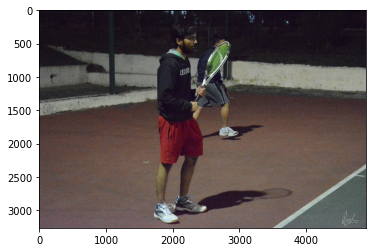

Generated Caption by greedy search :  windy measured shocked sled measured floored sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled
Generated Caption by beam search :  windy surfer sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled
Generated Caption by beam search with k = 5 :  windy surfer sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled
Generated Caption by beam search with k = 7 :  windy surfer sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled


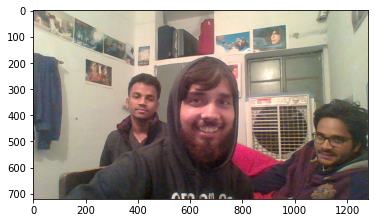

Generated Caption by greedy search :  sled stopaction windy poking celebrating pregnant language chickens prow pitcher scale measured carjack sled rippled jug propped sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled
Generated Caption by beam search :  stopaction windy poking chickens pregnant drips chickens prow pitcher scale measured sword sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled
Generated Caption by beam search with k = 5 :  windy living payer cleaned sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled
Generated Caption by beam search with k = 7 :  windy living payer cleaned sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled sled


In [ ]:
printing_img_desc('/content/drive/My Drive/Image Captioning Data/DSC_1858.jpg', model)
printing_img_desc('/content/drive/My Drive/Image Captioning Data/img.jpg', model)